In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data

### Data Preprocessing

- Data Source: [TradingView](https://cn.tradingview.com/)
  - Cardano (ADAUSDT)
  - Solana (SOLUSD)

In [3]:
cardano = pd.read_csv("/content/data/BINANCE_ADAUSDT, 60.csv")
solana = pd.read_csv("/content/data/FTX_SOLUSD, 60.csv")

In [4]:
cardano.head(5)

,time,open,high,low,close,Volume,Volume MA,Plot,Histogram,MACD,Signal,RSI,RSI-based MA,Upper Bollinger Band,Lower Bollinger Band,Bollinger Bands Width,Plot.1
0,2019-01-01T08:00:00+08:00,0.04057,0.04059,0.03995,0.04035,5902479.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7294.990642
1,2019-01-01T09:00:00+08:00,0.04040,0.04048,0.03987,0.04000,3739370.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5806.393346
2,2019-01-01T10:00:00+08:00,0.04004,0.04004,0.03964,0.03991,3615775.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5709.628827
3,2019-01-01T11:00:00+08:00,0.03988,0.04021,0.03985,0.04020,2419828.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4670.875288
4,2019-01-01T12:00:00+08:00,0.04020,0.04068,0.04017,0.04043,5649221.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7136.765597


In [5]:
solana.head(5)

,time,open,high,low,close,Volume,Volume MA,Plot,Histogram,MACD,Signal,RSI,RSI-based MA,Upper Bollinger Band,Lower Bollinger Band,Bollinger Bands Width,Plot.1
0,2020-04-10T13:00:00+08:00,0.838859,0.841505,0.829556,0.830813,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04-10T14:00:00+08:00,0.830813,0.830813,0.789543,0.789543,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-10T15:00:00+08:00,0.789543,0.789543,0.711701,0.744974,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-10T16:00:00+08:00,0.744974,0.790444,0.744974,0.776781,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-04-10T17:00:00+08:00,0.776781,0.776781,0.766247,0.775709,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 1. Drop columns that are all NaN or not sure about the meaning
cardano = cardano.drop(columns=['Upper Bollinger Band', 
                                'Lower Bollinger Band',
                                'Volume MA'])
solana = solana.drop(columns=['Upper Bollinger Band', 
                              'Lower Bollinger Band',
                              'Volume MA'])

In [7]:
# 2. Rename columns
rename_map = {
    "time": "Time",
    "open": "Open",
    "high": "High",
    "low": "Low",
    "close": "Close",
    "Plot": "Fear and Greed Index",
    "Plot.1": "FOMO Indicator"
}
cardano = cardano.rename(columns = rename_map)
solana = solana.rename(columns = rename_map)

In [8]:
# 4. Remove the first 33 rows for cardano since MACD is NaN
cardano = cardano.iloc[33:, :]
# Remove the first 2582 rows for solana since volume is 0
solana = solana.iloc[2582: , :]

In [9]:
cardano.isna().sum()

Time                     0
Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
Fear and Greed Index     0
Histogram                0
MACD                     0
Signal                   0
RSI                      0
RSI-based MA             0
Bollinger Bands Width    0
FOMO Indicator           1
dtype: int64

In [10]:
solana.isna().sum()

Time                       0
Open                       0
High                       0
Low                        0
Close                      0
Volume                     0
Fear and Greed Index       0
Histogram                  0
MACD                       0
Signal                     0
RSI                        0
RSI-based MA               0
Bollinger Bands Width      0
FOMO Indicator           186
dtype: int64

In [11]:
# fomo_mean = solana["FOMO Indicator"].mean()
# solana["FOMO Indicator"] = solana["FOMO Indicator"].fillna(fomo_mean)
fomo_mean = solana["FOMO Indicator"].mean()
solana["FOMO Indicator"] = solana["FOMO Indicator"].fillna(fomo_mean)
volume_mean = solana["Volume"].mean()
solana["Volume"] = solana["FOMO Indicator"].replace(0, fomo_mean)

In [12]:
solana.isna().sum()

Time                     0
Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
Fear and Greed Index     0
Histogram                0
MACD                     0
Signal                   0
RSI                      0
RSI-based MA             0
Bollinger Bands Width    0
FOMO Indicator           0
dtype: int64

In [13]:
# 5. Set the 'Time' for cardano to dataframe index
cardano = cardano.set_index('Time')

# Set the 'Time' for solana to dataframe index
solana = solana.set_index('Time')


In [14]:
# Convert cardano index to Datetime
cardano.index = pd.to_datetime(cardano.index)
# Convert solana index to Datetime
solana.index = pd.to_datetime(solana.index)

In [15]:
type(solana.index)

pandas.core.indexes.datetimes.DatetimeIndex

### Data Splitting

In [16]:
# 28423 rows for solana
cardano.shape

(28423, 13)

In [17]:
cardano

,Open,High,Low,Close,Volume,Fear and Greed Index,Histogram,MACD,Signal,RSI,RSI-based MA,Bollinger Bands Width,FOMO Indicator
Time,,,,,,,,,,,,,
2019-01-02 17:00:00+08:00,0.04213,0.04216,0.04176,0.04182,3035721.4,0.000056,-0.000021,0.000398,0.000419,58.964007,61.860057,0.060094,-5231.641531
2019-01-02 18:00:00+08:00,0.04184,0.04275,0.04170,0.04253,4181561.3,0.000032,0.000017,0.000441,0.000424,66.290553,62.129106,0.062255,-6140.108617
2019-01-02 19:00:00+08:00,0.04253,0.04333,0.04230,0.04276,10775592.5,0.000095,0.000051,0.000488,0.000436,68.267062,62.731770,0.063559,-9856.622293
2019-01-02 20:00:00+08:00,0.04269,0.04289,0.04238,0.04288,4672057.6,0.000201,0.000073,0.000528,0.000455,69.279150,63.310224,0.065529,-6490.244185
2019-01-02 21:00:00+08:00,0.04288,0.04340,0.04269,0.04311,9564761.4,0.000239,0.000094,0.000572,0.000478,71.176659,63.552029,0.065695,-9286.339305
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-03 08:00:00+08:00,1.15600,1.16900,1.15400,1.16100,4317775.5,0.001853,-0.002114,-0.003150,-0.001036,45.904212,47.240601,0.045768,-6239.314619
2022-04-03 09:00:00+08:00,1.16100,1.16200,1.14200,1.15600,6533554.6,0.002410,-0.002071,-0.003624,-0.001554,43.394560,46.202277,0.046320,-7675.069240
2022-04-03 10:00:00+08:00,1.15500,1.16000,1.14900,1.15300,2316847.1,0.001476,-0.002112,-0.004194,-0.002082,41.913902,45.058192,0.046466,-4570.412615


In [18]:
# 17281 rows for solana
solana.shape

(14765, 13)

In [19]:
# scaler = MinMaxScaler()
# cardano_copy = scaler.fit_transform(cardano.values)

In [20]:
# train_cardano = cardano_copy[:round(28423*0.8), :]
# test_cardano = cardano_copy[round(28423*0.8):, :]

In [21]:
# Take 80% data for training, 20% for testing
train_cardano = cardano.iloc[:round(28423*0.8), :]
test_cardano = cardano.iloc[round(28423*0.8):, :]
train_solana = solana.iloc[:round(14765*0.8), :]
test_solana = solana.iloc[round(14765*0.8):, :]

In [22]:

# window_data = []
# for idx in range(len(df) - window_len):
#     tmp = df[idx: (idx + window_len)].copy()
#     if zero_base:
#         tmp = normalise_zero_base(tmp)
    # scaler.fit(tmp)
    # scaler.transform(tmp)



# features = dfm[["open","high","low","close"]].values
#   #print(features)
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(features)

In [23]:
len(train_cardano) + len(test_cardano)

28423

In [24]:
len(train_solana) + len(test_solana)

14765

In [25]:
train_cardano.head()

,Open,High,Low,Close,Volume,Fear and Greed Index,Histogram,MACD,Signal,RSI,RSI-based MA,Bollinger Bands Width,FOMO Indicator
Time,,,,,,,,,,,,,
2019-01-02 17:00:00+08:00,0.04213,0.04216,0.04176,0.04182,3035721.4,0.000056,-0.000021,0.000398,0.000419,58.964007,61.860057,0.060094,-5231.641531
2019-01-02 18:00:00+08:00,0.04184,0.04275,0.04170,0.04253,4181561.3,0.000032,0.000017,0.000441,0.000424,66.290553,62.129106,0.062255,-6140.108617
2019-01-02 19:00:00+08:00,0.04253,0.04333,0.04230,0.04276,10775592.5,0.000095,0.000051,0.000488,0.000436,68.267062,62.731770,0.063559,-9856.622293
2019-01-02 20:00:00+08:00,0.04269,0.04289,0.04238,0.04288,4672057.6,0.000201,0.000073,0.000528,0.000455,69.279150,63.310224,0.065529,-6490.244185
2019-01-02 21:00:00+08:00,0.04288,0.04340,0.04269,0.04311,9564761.4,0.000239,0.000094,0.000572,0.000478,71.176659,63.552029,0.065695,-9286.339305


### Context

**1. Crypto Basic Information**
- **Time**: Time period
- **Open**: Price at which the crypto began in the time period
- **High**: Max price in the time priod
- **Low**: Min price in the time priod
- **Close**: Price at which the crypto ended in the time period
- **Volume**: Sum total of actual trades taking place in the time period

**2. Techinical Analysis Indicators**
- **Moving Average Convergence Divergence (MACD)**
  - Histogram
  - MACD
  - Signal
- **Relative Strength Index (RSI)**
  - RSI
  - RSI-based MA
- **Bollinger Bands Width**

**3. Cryptocurrency Social Media Indicator**
- **Crypto FOMO Indicator**
- **The Fear and Greed Index**

### Data Visualization and Preparation

In [26]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [27]:
def line_plot_v2(line1, line2, line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [28]:
target_col = 'Close'

In [29]:
# line_plot(train_cardano[:, 3], test_cardano[:, 3], 'training', 'test', title='Cardano')

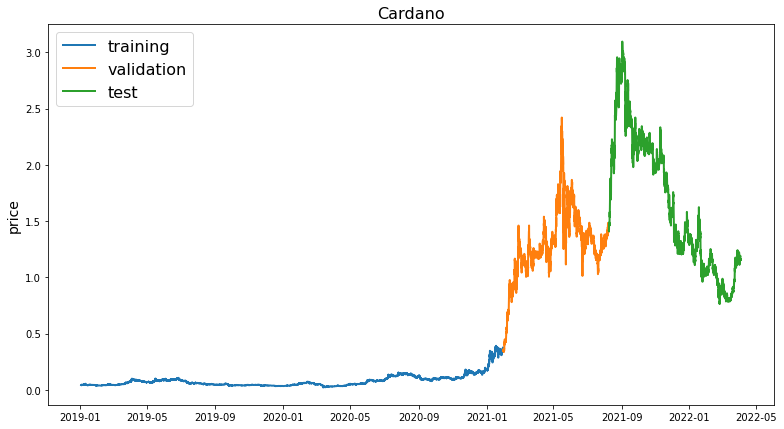

In [30]:
line_plot_v2(train_cardano.iloc[:round(len(train_cardano)*0.8), :][target_col], train_cardano.iloc[round(len(train_cardano)*0.8):, :][target_col], test_cardano[target_col], 'training', 'validation', 'test', title='Cardano')

In [31]:
train_cardano.head()

,Open,High,Low,Close,Volume,Fear and Greed Index,Histogram,MACD,Signal,RSI,RSI-based MA,Bollinger Bands Width,FOMO Indicator
Time,,,,,,,,,,,,,
2019-01-02 17:00:00+08:00,0.04213,0.04216,0.04176,0.04182,3035721.4,0.000056,-0.000021,0.000398,0.000419,58.964007,61.860057,0.060094,-5231.641531
2019-01-02 18:00:00+08:00,0.04184,0.04275,0.04170,0.04253,4181561.3,0.000032,0.000017,0.000441,0.000424,66.290553,62.129106,0.062255,-6140.108617
2019-01-02 19:00:00+08:00,0.04253,0.04333,0.04230,0.04276,10775592.5,0.000095,0.000051,0.000488,0.000436,68.267062,62.731770,0.063559,-9856.622293
2019-01-02 20:00:00+08:00,0.04269,0.04289,0.04238,0.04288,4672057.6,0.000201,0.000073,0.000528,0.000455,69.279150,63.310224,0.065529,-6490.244185
2019-01-02 21:00:00+08:00,0.04288,0.04340,0.04269,0.04311,9564761.4,0.000239,0.000094,0.000572,0.000478,71.176659,63.552029,0.065695,-9286.339305


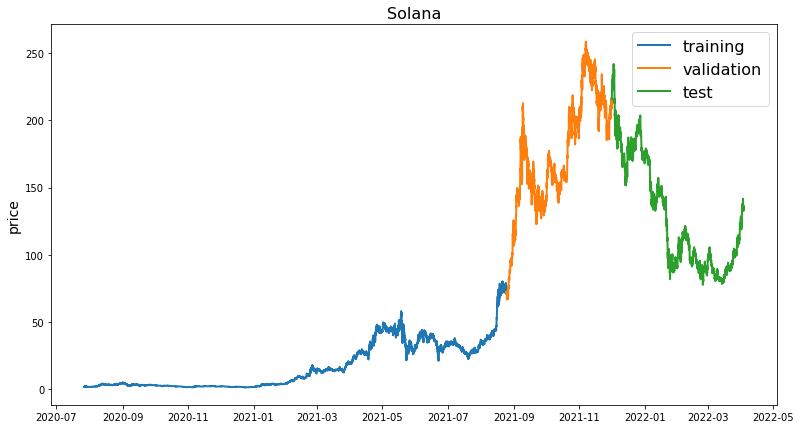

In [32]:
line_plot_v2(train_solana.iloc[:round(len(train_solana)*0.8), :][target_col], train_solana.iloc[round(len(train_solana)*0.8):, :][target_col], test_solana[target_col], 'training', 'validation', 'test', title='Solana')

In [33]:
def normalise_by_first_line(df):
    # print(df.iloc[0])
    return df / df.iloc[0]

In [34]:
def get_data(df, window_len, zero_base):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
          tmp = normalise_by_first_line(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True):
    # train validation split
    train_data = df.iloc[:round(len(df)*0.8), :]
    test_data = df.iloc[round(len(df)*0.8):, :]

    X_train = get_data(train_data, window_len, zero_base)
    X_test = get_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
      y_train = y_train / train_data[target_col][:-window_len].values - 1
      y_test = y_test / test_data[target_col][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [39]:
def prepare_test(df, target_col, window_len=10, zero_base=True):
    X_test = get_data(df, window_len, zero_base)
    y_test = df[target_col][window_len:].values
    if zero_base:
      y_test = y_test / df[target_col][:-window_len].values - 1
    return X_test, y_test

##### Evaluation

In [41]:
def SMAPE(actual, pred) -> float:

    assert actual.shape == pred.shape
  
    return round(
        np.mean(np.abs(pred - actual) / 
                ((np.abs(pred) + np.abs(actual))/2))*100, 2)

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [43]:
def evaluate(model, X_test, y_test, test_data, norm = True):
    # targets = test[target_col][window_len:]
    y_pred = model.predict(X_test).squeeze()
    if norm:
      y_pred = test_data[target_col].values[:-window_len] * (y_pred + 1)
      # y_pred = pd.Series(index=targets.index, data=y_pred)
      y_test = test_data[target_col].values[:-window_len] * (y_test + 1)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # SMAPE
    smape = SMAPE(y_test, y_pred)

    # Trend Prediction Accuracy
    pred_trend = ((y_pred[1:] - y_test[:-1]) >= 0)
    actual_trend = ((y_test[1:] - y_test[:-1]) >= 0)
    trend_pred_acc = np.sum(pred_trend == actual_trend)/len(pred_trend)

    print("RMSE: {}".format(rmse))
    print("MAPE: {}%".format(mape*100))
    print("sMAPE: {}%".format(smape))
    print("Trend Prediction Accuracy: {}".format(trend_pred_acc))

### Models

#### LSTM

In [44]:
%tensorflow_version 2.x
import json
import requests
import tensorflow
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, GRU
import keras.losses as kr
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [45]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    # print('hi0')
    model.add(LSTM(neurons, input_shape = (input_data.shape[1], input_data.shape[2])))
    # print('hi1')
    model.add(Dropout(dropout))
    # print('hi2')
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

##### *training on Cardano*

In [46]:
np.random.seed(42)
window_len = 5
# test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 128
loss = kr.MeanAbsoluteError()
dropout = 0.2
adam = Adam(learning_rate=0.0001)
optimizer = adam

In [47]:
train_cardano.shape

(22738, 13)

In [48]:
# if zero_base:
train, val, X_train, X_val, y_train, y_val = prepare_data(train_cardano, target_col, window_len=window_len, zero_base=zero_base)

In [ ]:
X_train

In [50]:
y_val.shape

(4543,)

In [51]:
cardano_lstm = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = cardano_lstm.fit(X_train.astype(np.float32), y_train.astype(np.float32), validation_data=(X_val.astype(np.float32), y_val.astype(np.float32)), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
143/143 [==============================] - 3s 7ms/step - loss: 0.1337 - val_loss: 0.0393
Epoch 2/20
143/143 [==============================] - 1s 4ms/step - loss: 0.0961 - val_loss: 0.0318
Epoch 3/20
143/143 [==============================] - 1s 4ms/step - loss: 0.0792 - val_loss: 0.0293
Epoch 4/20
143/143 [==============================] - 1s 5ms/step - loss: 0.0663 - val_loss: 0.0277
Epoch 5/20
143/143 [==============================] - 1s 5ms/step - loss: 0.0579 - val_loss: 0.0260
Epoch 6/20
143/143 [==============================] - 1s 4ms/step - loss: 0.0506 - val_loss: 0.0247
Epoch 7/20
143/143 [==============================] - 1s 5ms/step - loss: 0.0452 - val_loss: 0.0241
Epoch 8/20
143/143 [==============================] - 1s 5ms/step - loss: 0.0404 - val_loss: 0.0234
Epoch 9/20
143/143 [==============================] - 1s 5ms/step - loss: 0.0373 - val_loss: 0.0229
Epoch 10/20
143/143 [==============================] - 1s 4ms/step - loss: 0.0341 - val_loss: 0.0220

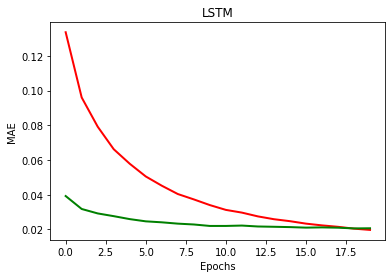

In [52]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [53]:
X_test, y_test = prepare_test(test_cardano, target_col, window_len=window_len, zero_base=True)

In [54]:
evaluate(cardano_lstm, X_test, y_test, test_cardano)

RMSE: 0.039846748762644706
MAPE: 1.4063032186442364%
sMAPE: 1.4%
Trend Prediction Accuracy: 0.5263250572283853


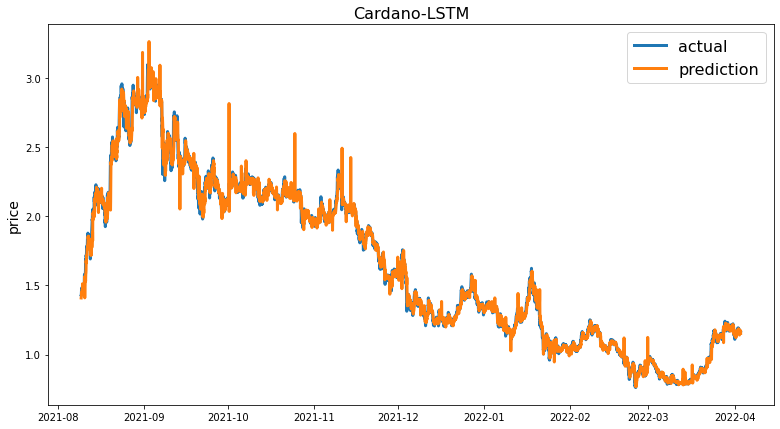

In [55]:
targets = test_cardano[target_col][window_len:]
preds = cardano_lstm.predict(X_test).squeeze()
preds = test_cardano[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3, title='Cardano-LSTM')

##### *training on Solana*

In [66]:
np.random.seed(42)
window_len = 10
# test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 256
loss = kr.MeanAbsoluteError()
dropout = 0.2
adam = Adam(learning_rate=0.001)
optimizer = adam

In [67]:
train, val, X_train, X_val, y_train, y_val = prepare_data(train_solana, target_col, window_len=window_len, zero_base=zero_base)

In [ ]:
X_train.shape

In [68]:
solana_lstm = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = solana_lstm.fit(X_train.astype(np.float32), y_train.astype(np.float32), validation_data=(X_val.astype(np.float32), y_val.astype(np.float32)), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
37/37 [==============================] - 2s 15ms/step - loss: 0.1872 - val_loss: 0.0492
Epoch 2/20
37/37 [==============================] - 0s 5ms/step - loss: 0.1238 - val_loss: 0.0423
Epoch 3/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0989 - val_loss: 0.0391
Epoch 4/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0807 - val_loss: 0.0356
Epoch 5/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0702 - val_loss: 0.0324
Epoch 6/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0597 - val_loss: 0.0288
Epoch 7/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0514 - val_loss: 0.0266
Epoch 8/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0477 - val_loss: 0.0262
Epoch 9/20
37/37 [==============================] - 0s 6ms/step - loss: 0.0436 - val_loss: 0.0257
Epoch 10/20
37/37 [==============================] - 0s 5ms/step - loss: 0.0414 - val_loss: 0.0247
Epoch 11/20
37/37 

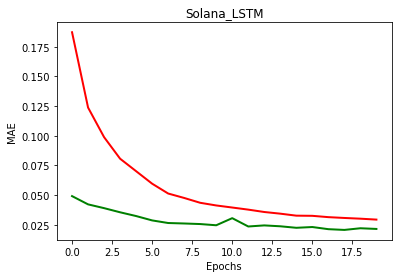

In [69]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Solana_LSTM')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [70]:
X_test, y_test = prepare_test(test_solana, target_col, window_len=window_len, zero_base=True)

In [71]:
evaluate(solana_lstm, X_test, y_test, test_solana)

RMSE: 3.7626534646581127
MAPE: 2.0128407322575614%
sMAPE: 1.99%
Trend Prediction Accuracy: 0.5152957171991842


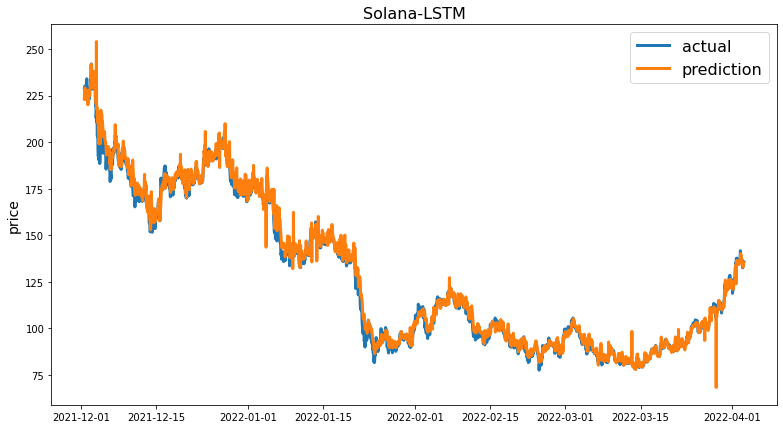

In [72]:
targets = test_solana[target_col][window_len:]
preds = solana_lstm.predict(X_test).squeeze()
preds = test_solana[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3, title='Solana-LSTM')

#### GRU

In [73]:
def build_gru_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(neurons, input_shape=(input_data.shape[1], input_data.shape[2]),return_sequences=False))
    model.add(Activation('tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(output_size))
    model.add(Activation('relu'))
    model.compile(loss='mse', optimizer=optimizer)

    return model

##### GRU on Cardano

In [ ]:
np.random.seed(42)
window_len = 5
# test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 10
batch_size = 32
loss = kr.MeanAbsoluteError()
dropout = 0.2
adam = Adam(learning_rate=0.00001)
optimizer = adam

In [ ]:
train, val, X_train, X_val, y_train, y_val = prepare_data(train_cardano, target_col, window_len=window_len, zero_base=zero_base)

In [ ]:
cardano_gru = build_gru_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, 
    optimizer=optimizer)
history = cardano_gru.fit(
    X_train.astype(np.float32), y_train.astype(np.float32), validation_data=(X_val.astype(np.float32), y_val.astype(np.float32)), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Cardano_GRU')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [ ]:
X_test, y_test = prepare_test(test_cardano, target_col, window_len=window_len, zero_base=True)

In [ ]:
evaluate(cardano_gru, X_test, y_test, test_cardano)

In [ ]:
targets = test_cardano[target_col][window_len:]
preds = cardano_gru.predict(X_test).squeeze()
preds = test_cardano[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3, title='Cardano-GRU')

##### GRU on Solana

In [94]:
np.random.seed(42)
window_len = 5
# test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 20
batch_size = 32
loss = kr.MeanAbsoluteError()
dropout = 0.2
adam = Adam(learning_rate=0.00001)
optimizer = adam

In [75]:
train, val, X_train, X_val, y_train, y_val = prepare_data(train_solana, target_col, window_len=window_len, zero_base=zero_base)

In [127]:
y_train

array([ 0.0676259 , -0.04054054,  0.07309942, ..., -0.07024967,
       -0.09025456, -0.08207287])

In [95]:
solana_gru = build_gru_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, 
    optimizer=optimizer)
history = solana_gru.fit(
    X_train.astype(np.float32), y_train.astype(np.float32), validation_data=(X_val.astype(np.float32), y_val.astype(np.float32)), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
296/296 [==============================] - 3s 5ms/step - loss: 0.1023 - val_loss: 0.0224
Epoch 2/20
296/296 [==============================] - 1s 4ms/step - loss: 0.0435 - val_loss: 0.0085
Epoch 3/20
296/296 [==============================] - 1s 4ms/step - loss: 0.0252 - val_loss: 0.0049
Epoch 4/20
296/296 [==============================] - 1s 4ms/step - loss: 0.0193 - val_loss: 0.0033
Epoch 5/20
296/296 [==============================] - 1s 4ms/step - loss: 0.0150 - val_loss: 0.0026
Epoch 6/20
296/296 [==============================] - 1s 4ms/step - loss: 0.0109 - val_loss: 0.0022
Epoch 7/20
296/296 [==============================] - 1s 4ms/step - loss: 0.0106 - val_loss: 0.0020
Epoch 8/20
296/296 [==============================] - 1s 4ms/step - loss: 0.0089 - val_loss: 0.0018
Epoch 9/20
296/296 [==============================] - 1s 4ms/step - loss: 0.0073 - val_loss: 0.0017
Epoch 10/20
296/296 [==============================] - 1s 4ms/step - loss: 0.0070 - val_loss: 0.0016

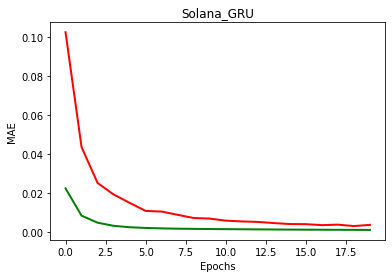

In [96]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Solana_GRU')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [78]:
X_test, y_test = prepare_test(test_solana, target_col, window_len=window_len, zero_base=True)

In [97]:
evaluate(solana_gru, X_test, y_test, test_solana)

RMSE: 3.535094071808301
MAPE: 1.9815627541853242%
sMAPE: 1.98%
Trend Prediction Accuracy: 0.5215473362741772


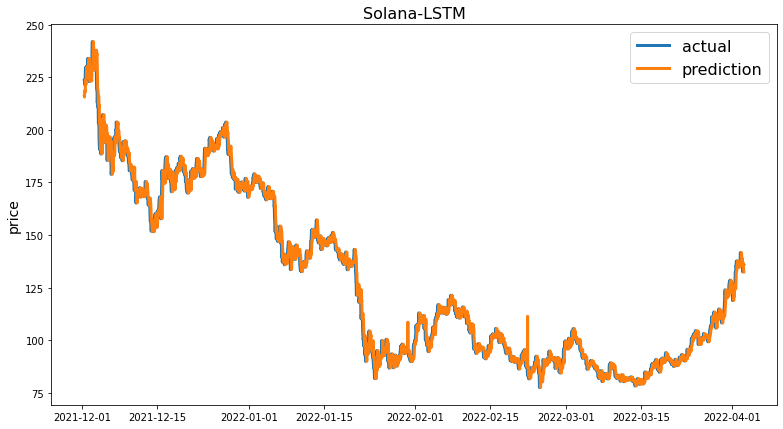

In [98]:
targets = test_solana[target_col][window_len:]
preds = solana_gru.predict(X_test).squeeze()
preds = test_solana[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3, title='Solana-LSTM')

#### Bi-LSTM

In [99]:
from keras.layers import Bidirectional

In [100]:
def build_bi_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]))))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))


    model.compile(loss=loss, optimizer=optimizer)
    return model

#### Bi-LSTM on Cardano

In [ ]:
np.random.seed(42)
window_len = 10
zero_base = True
lstm_neurons = 50
epochs = 10
batch_size = 150
loss = kr.MeanAbsoluteError()
dropout = 0.2
adam = Adam(learning_rate=0.001)
optimizer = adam

In [ ]:
train, val, X_train, X_val, y_train, y_val = prepare_data(train_cardano, target_col, window_len=window_len, zero_base=zero_base)

In [ ]:
cardano_bi = build_bi_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, 
    optimizer=optimizer)
history = cardano_bi.fit(
    X_train.astype(np.float32), y_train.astype(np.float32), validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/10
122/122 [==============================] - 7s 12ms/step - loss: 0.0295 - val_loss: 0.0028
Epoch 2/10
122/122 [==============================] - 1s 6ms/step - loss: 0.0085 - val_loss: 0.0016
Epoch 3/10
122/122 [==============================] - 1s 7ms/step - loss: 0.0045 - val_loss: 0.0013
Epoch 4/10
122/122 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 5/10
122/122 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 6/10
122/122 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 7/10
122/122 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 8/10
122/122 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 9.5899e-04
Epoch 9/10
122/122 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 9.0283e-04
Epoch 10/10
122/122 [==============================] - 1s 7ms/step - loss: 0.0011 - val_los

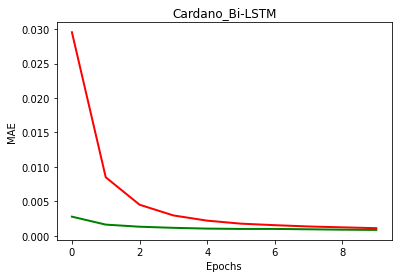

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Cardano_Bi-LSTM')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [ ]:
X_test, y_test = prepare_test(test_cardano, target_col, window_len=window_len, zero_base=True)

In [ ]:
evaluate(cardano_bi, X_test, y_test, test_cardano)

RMSE: 0.051819723878549016
MAPE: 2.0675132394472002%
sMAPE: 2.06%
Trend Prediction Accuracy: 0.5206203736341205


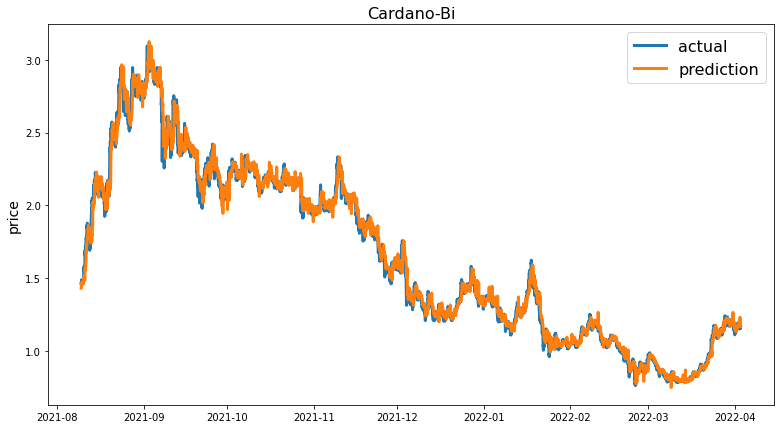

In [ ]:
targets = test_cardano[target_col][window_len:]
preds = cardano_bi.predict(X_test).squeeze()
preds = test_cardano[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3, title='Cardano-Bi')

##### Bi-LSTM on Solana

In [110]:
np.random.seed(42)
window_len = 5
zero_base = True
lstm_neurons = 50
epochs = 10
batch_size = 150
loss = kr.MeanAbsoluteError()
dropout = 0.2
adam = Adam(learning_rate=0.001)
optimizer = adam

In [111]:
train, val, X_train, X_val, y_train, y_val = prepare_data(train_solana, target_col, window_len=window_len, zero_base=zero_base)

In [112]:
solana_bi = build_bi_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, 
    optimizer=optimizer)
history = solana_bi.fit(
    X_train.astype(np.float32), y_train.astype(np.float32), validation_data=(X_val.astype(np.float32), y_val.astype(np.float32)), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/10
63/63 [==============================] - 7s 41ms/step - loss: 0.0425 - val_loss: 0.0026
Epoch 2/10
63/63 [==============================] - 1s 10ms/step - loss: 0.0176 - val_loss: 0.0017
Epoch 3/10
63/63 [==============================] - 1s 12ms/step - loss: 0.0115 - val_loss: 0.0013
Epoch 4/10
63/63 [==============================] - 1s 11ms/step - loss: 0.0081 - val_loss: 0.0013
Epoch 5/10
63/63 [==============================] - 1s 11ms/step - loss: 0.0061 - val_loss: 0.0010
Epoch 6/10
63/63 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 9.1810e-04
Epoch 7/10
63/63 [==============================] - 0s 7ms/step - loss: 0.0042 - val_loss: 9.2498e-04
Epoch 8/10
63/63 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 9.4817e-04
Epoch 9/10
63/63 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 8.5683e-04
Epoch 10/10
63/63 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 8.039

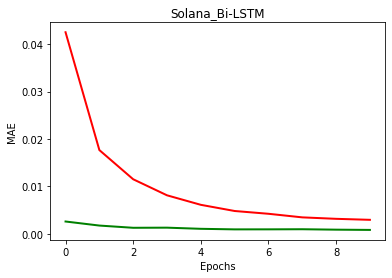

In [113]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Solana_Bi-LSTM')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [115]:
X_test, y_test = prepare_test(test_solana, target_col, window_len=window_len, zero_base=True)

In [116]:
evaluate(solana_bi, X_test, y_test, test_solana)

RMSE: 3.2399267076768146
MAPE: 1.7259666189087859%
sMAPE: 1.72%
Trend Prediction Accuracy: 0.502884289107567


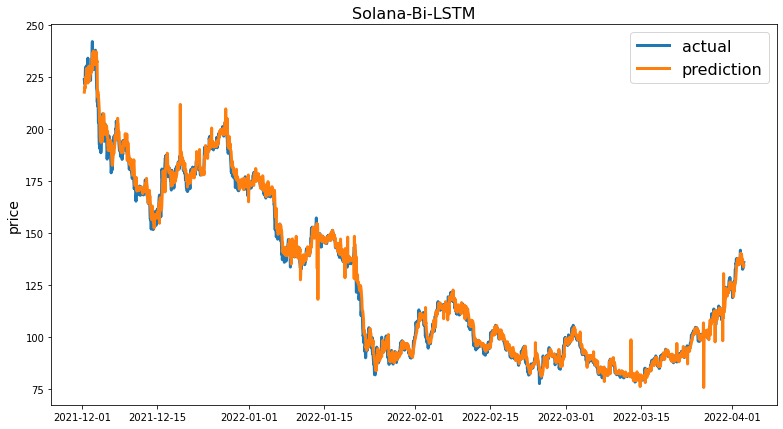

In [117]:
targets = test_solana[target_col][window_len:]
preds = solana_bi.predict(X_test).squeeze()
preds = test_solana[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3, title='Solana-Bi-LSTM')